CNN 모델보다 성능은 다소 떨어지지만, 최대한 다양한 모델을 사용해보기 위해,   
mid-level features를 이용해 model을 만들어 예측해 보았다.

### 0. Mid-level features
- GLCM ([paper link](https://arxiv.org/ftp/arxiv/papers/1205/1205.4831.pdf))
- TEM ([paper link](https://openscholarship.wustl.edu/cgi/viewcontent.cgi?article=1812&context=cse_research))
     
         
### 1. Classification Model
- Basian Classifier
- MLP (NN)

In [14]:
import numpy as np
from scipy import signal as sg
from skimage.feature import graycomatrix, graycoprops    # glcm
import os
import matplotlib.pyplot as plt
import itertools    # confusion matrix에서 사용

from PIL import Image
from torchvision.datasets import ImageFolder

## TEM (Law's Energy Measure)

In [4]:
def laws_texture(image):
    # Law's Texture mask 생성
    basic_mask = np.array([[1, 4, 6, 4, 1],  # L5
                           [-1, -2, 0, 2, 1],  # E5
                           [-1, 0, 2, 0, 1],  # S5
                           [1, -4, 6, -4, 1]])  # R5
    filters = []  # 2D convoution mask 저장 리스트
    for i in range(4):
        for j in range(4):
            filters.append(np.matmul(basic_mask[i][:].reshape(5, 1),
                                     basic_mask[j][:].reshape(1, 5)))
    # 0 : L5L5, 1 : L5E5, 2 : L5S5, 3 : L5R5, 4 : E5L5, 5 : E5E5, 6 : E5S5, 7 : E5R5,
    # 8 : S5L5, 9 : S5E5, 10 : S5S5, 11 : S5R5, 12 : R5L5, 13 : R5E5, 14 : R5S5, 15 : R5R5

    # symmetric한 pair는 합치기
    filters_combine = []  # 합친 mask 저장
    filters_combine.append((filters[1] + filters[4]) // 2)  # L5E5 / E5L5
    filters_combine.append((filters[2] + filters[8]) // 2)  # L5S5 / S5L5
    filters_combine.append((filters[3] + filters[12]) // 2)  # L5R5 / R5L5
    filters_combine.append((filters[7] + filters[13]) // 2)  # E5R5 / R5E5
    filters_combine.append((filters[6] + filters[9]) // 2)  # E5S5 / S5E5
    filters_combine.append((filters[11] + filters[14]) // 2)  # S5R5 / R5S5
    filters_combine.append(filters[10])  # S5S5
    filters_combine.append(filters[5])  # E5E5
    filters_combine.append(filters[15])  # R5R5
    filters_combine.append(filters[0])  # L5L5 -> normalize 위해 필요

    # 이미지 불러와서 커널 적용시키기
    mean_kernel = (1 / 25) * np.ones((5, 5))
    TEM_by_image = []  # 각 이미지 별로 9개의 TEM값 저장 -> 9-dim vector
    # 이미지 전처리하기 -> edge를 용이하게 추출할 수 있도록
    gray_smooth = sg.convolve(image, mean_kernel, 'same')
    gray_processed = np.abs(image - gray_smooth)

    # convolution 연산하여 커널 적용
    conv_result = []
    for filter in filters_combine:
        conv_result.append(sg.convolve(gray_processed, filter, 'same'))

    # TEM 계산
    for i in range(9):
        TEM_by_image.append(np.abs(conv_result[i]).sum() / np.abs(conv_result[9]).sum())
    return TEM_by_image

## GLCM (Gray-Level Co-occurrence Matrix)

In [36]:
def glcm(gray):
    glcm_features = []    # 12-dim vector
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=False, normed=True)
    glcm2 = graycomatrix(gray, distances=[1], angles=[np.pi/2], levels=256, symmetric=False, normed=True)  # 수직 방향
    glcm3 = graycomatrix(gray, distances=[1], angles=[np.pi/4], levels=256, symmetric=False, normed=True) # 대각 방향
    glcm_features.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    glcm_features.append(graycoprops(glcm, 'correlation')[0, 0])
    glcm_features.append(graycoprops(glcm, 'contrast')[0, 0])
    glcm_features.append(graycoprops(glcm, 'homogeneity')[0, 0])
    glcm_features.append(graycoprops(glcm2, 'dissimilarity')[0, 0])
    glcm_features.append(graycoprops(glcm2, 'correlation')[0, 0])
    glcm_features.append(graycoprops(glcm2, 'contrast')[0, 0])
    glcm_features.append(graycoprops(glcm2, 'homogeneity')[0, 0])
    glcm_features.append(graycoprops(glcm3, 'dissimilarity')[0, 0])
    glcm_features.append(graycoprops(glcm3, 'correlation')[0, 0])
    glcm_features.append(graycoprops(glcm3, 'contrast')[0, 0])
    glcm_features.append(graycoprops(glcm3, 'homogeneity')[0, 0])
    
    return glcm_features

## Data Loading

In [6]:
# Create own dataset class
class textureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):    # idx가 pytorch tensor면
            idx = idx.tolist()
        feature = self.features[idx]
        label = self.labels[idx]
        sample = (feature, label)

        return sample

In [7]:
from torchvision import transforms

transform=transforms.Compose([
      transforms.Grayscale(num_output_channels=1),
])
dataset = ImageFolder(root="/kaggle/input/devkor-image-classification/train",
                      transform=transform)
# [(image, label), ...] 형태

In [121]:
img = np.array(dataset[0][0])
print(img.shape)

(28, 28)


In [39]:
import cv2

# 이미지 열기, feature 특징 추출 후 X, y 값 반환
def make_images_features_train(dataset):
    # train data 저장

    X_train = []
    y_train = []

    for img, label in dataset:
        glcm_features = glcm(img)    # 12-d vector
        tem_features = laws_texture(img)    # 9-d vector
        X_train.append(glcm_features + tem_features)
        y_train.append(label)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    print(X_train.shape)
    print(y_train.shape)

    return X_train, y_train

In [132]:
!pip install natsort

In [135]:
import natsort
image_dir = '/kaggle/input/devkor-image-classification/test'
listdir = os.listdir(image_dir)
print(listdir[:10])
sorted_dir = natsort.natsorted(listdir)
print(sorted_dir[:10])

['9273.png', '9292.png', '0566.png', '4353.png', '7968.png', '6490.png', '5511.png', '6262.png', '2664.png', '0115.png']
['0000.png', '0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png']


In [136]:
def make_images_features_test():
    # test data 저장

    X_test = []

    # imageloader를 쓸 수 없으므로 그냥 해야겟당,,
    image_dir = '/kaggle/input/devkor-image-classification/test'
    listdir = os.listdir(image_dir)
    sorted_dir = natsort.natsorted(listdir)
    for image_name in sorted_dir:
        img = cv2.imread(os.path.join(image_dir, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        glcm_features = glcm(img)    # 12-d vector
        tem_features = laws_texture(img)    # 9-d vector
        X_test.append(glcm_features + tem_features)

    X_test = np.array(X_test)

    print(X_test.shape)

    return X_test

In [40]:
X_train, y_train = make_images_features_train(dataset)

(60000, 21)
(60000,)
(10000, 21)


In [137]:
X_test = make_images_features_test()

(10000, 21)


In [56]:
train_size = int(len(X_train) * 0.8)
val_size = len(X_train) - train_size

# X_train, y_train 동시 shuffle
idx_randomize = np.arange(len(y_train))
np.random.shuffle(idx_randomize)

X_train_shuf = X_train[idx_randomize]
y_train_shuf = y_train[idx_randomize]
X_train2 = X_train_shuf[:train_size]
y_train2 = y_train_shuf[:train_size]
X_val = X_train_shuf[train_size:]
y_val = y_train_shuf[train_size:]

In [60]:
print(X_train2.shape)
print(y_train2.shape)
print(X_val.shape)
print(y_val.shape)

(48000, 21)
(48000,)
(12000, 21)
(12000,)


## Bayesian Classifier

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
              'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [114]:
def bayesian_classifier(X_train, y_train, X_val, y_val):
    priors = []
    covariances = []
    means = []

    for i in range(len(classes)):
        X = X_train[y_train == i]
        priors.append(len(X) / len(X_train))    # 사전확률
        means.append(np.mean(X, axis=0))    # 평균값
        covariances.append(np.cov(np.transpose(X), bias=True))
    # likehood 계산
    def likelihood(x, prior, mean, cov):
        return -0.5 * np.linalg.multi_dot([np.transpose(x - mean), np.linalg.inv(cov), (x - mean)]) - 0.5 * np.log(np.linalg.det(cov)) + np.log(prior)

    y_pred = []
    for i in range(len(X_val)):
        likelihoods = []
        for j in range(len(classes)):
            likelihoods.append(likelihood(X_val[i], priors[j], means[j], covariances[j]))
        # print(likelihoods)
        y_pred.append(likelihoods.index(max(likelihoods)))  # 확률이 가장 큰 값으로 인덱싱
    acc = accuracy_score(y_val, y_pred)
    print("accuracy : ", acc)

    return y_pred

In [115]:
y_pred = bayesian_classifier(X_train2, y_train2, X_val, y_val)

accuracy :  0.7050833333333333


MLP, CNN보다는 아니지만 나쁘지 않은 정확도를 가진다.

In [128]:
# confusion matrix 시각화
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, target_names=None, labels=True):
    accuracy = np.trace(cm) / float(np.sum(cm))

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    thresh = cm.max() / 2

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

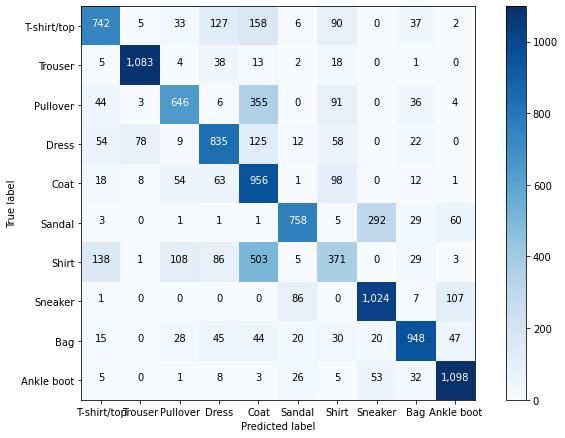

In [129]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), target_names=classes)

In [130]:
# val로 split 안하고 모든 train dataset 이용하여 test dataset 예측
def bayesian_classifier_without_acc(X_train, y_train, X_val):
    priors = []
    covariances = []
    means = []

    for i in range(len(classes)):
        X = X_train[y_train == i]
        priors.append(len(X) / len(X_train))    # 사전확률
        means.append(np.mean(X, axis=0))    # 평균값
        covariances.append(np.cov(np.transpose(X), bias=True))
    # likehood 계산
    def likelihood(x, prior, mean, cov):
        return -0.5 * np.linalg.multi_dot([np.transpose(x - mean), np.linalg.inv(cov), (x - mean)]) - 0.5 * np.log(np.linalg.det(cov)) + np.log(prior)

    y_pred = []
    for i in range(len(X_val)):
        likelihoods = []
        for j in range(len(classes)):
            likelihoods.append(likelihood(X_val[i], priors[j], means[j], covariances[j]))
        y_pred.append(likelihoods.index(max(likelihoods)))  # 확률이 가장 큰 값으로 인덱싱
    #acc = accuracy_score(y_val, y_pred)
    #print("accuracy : ", acc)

    return y_pred

In [138]:
y_pred2 = bayesian_classifier_without_acc(X_train, y_train, X_test)

In [139]:
import pandas as pd

submission = pd.read_csv("/kaggle/input/devkor-image-classification/sample_submission.csv")
submission.head()

,idx,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [140]:
submission.loc[:, "label"] = y_pred2
submission.to_csv("result_bayesian.csv", index=False)
submission.head()

,idx,label
0,0,9
1,1,2
2,2,1
3,3,1
4,4,4


제출 결과 acc : 0.69633

## MLP

In [141]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from torchsummary import summary

In [143]:
class textureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):    # idx가 pytorch tensor면
            idx = idx.tolist()
        feature = self.features[idx]
        label = self.labels[idx]
        sample = (feature, label)

        return sample

In [180]:
class testDataset(Dataset):
    def __init__(self, features):
        super().__init__()
        self.features = features
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        features = self.features[idx]
        
        return features

In [146]:
batch_size = 128

train2_data = textureDataset(features=X_train2, labels=y_train2)
val_data = textureDataset(features=X_val, labels=y_val)

train_data = textureDataset(features=X_train, labels=y_train)
test_data = testDataset(features=X_test)

train2_loader = DataLoader(train2_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [176]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [142]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim2, output_dim):
        super(MLP, self).__init__()     # 부모 클래스(nn.Module)를 초기화
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):   # x : input_dim
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)

        return out

In [151]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP(21, 64, 32, 10).to(device)     # input, hidden, hiden2, output dim.
# summary(model, (21, ), device)

# batch_size = 128
learning_rate = 0.001
n_epoch = 300

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [152]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []

In [158]:
for epoch in range(n_epoch):
    # Training
    train_loss = 0.0
    evaluation = []     # 예측 정확 여부(true, false) 저장 배열
    model.train()
    for features, labels in train2_loader:
        features = features.to(device)      # fetures를 device로 보내기
        labels = labels.to(device)   # label을 device로 보내기
        outputs = model(features.to(torch.float))     # 특징을 float형으로 반환 후 모델에 입력
        # float으로 변환하는 과정이 꼭 필요할까?
        
        optimizer.zero_grad()   # optimizer의 gradient를 0으로 초기화
        _, predicted = torch.max(outputs.cpu().data, 1)     # 출력 제일 큰 값의 index 반환

        evaluation.append((predicted == labels.cpu()).tolist())     # 예측이 맞았는지 여부 저장
        loss = criterion(outputs, labels)   # loss 계산

        loss.backward()     # 역전파, 기울기 계산
        optimizer.step()    # 가중치 값 업데이트, 학습 한 번 진행

        train_loss += loss.item()   # loss 누적값 구하기

    train_loss = train_loss / (batch_size * (epoch + 1))   # 평균 train_loss 구하기
    evaluation = [item for sublist in evaluation for item in sublist]   # 2차원 배열을 1차원으로 바꿈
    train_acc = sum(evaluation) / len(evaluation)   # accuracy 구하기 (True 비율)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    
    # Validation
    # if (epoch + 1) % 1 == 0:    # 뭐지 정수일때만? 돌리는건가?
    test_loss = 0.0
    evaluation = []  # 예측 정확 여부(true, false) 저장 배열
    model.eval()  # 모델을 평가 모드로 전환
    for features, labels in val_loader:
        labels = labels.long().to(device)
        features = features.to(device)

        outputs = model(features.to(torch.float))

        _, predicted = torch.max(outputs.cpu().data, 1)

        evaluation.append((predicted == labels.cpu()).tolist())  # 예측이 맞았는지 여부 저장
        loss = criterion(outputs, labels)  # loss 계산

        test_loss += loss.item()  # loss 누적값 구하기

    test_loss = test_loss / (batch_size * (epoch + 1))  # 평균 train_loss 구하기
    evaluation = [item for sublist in evaluation for item in sublist]  # 2차원 배열을 1차원으로 바꿈
    test_acc = sum(evaluation) / len(evaluation)  # accuracy 구하기 (True 비율)

    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print("[%d, %3d]\tloss : %.4f\tAccuracy : %.4f\t\tval-loss : %.4f\tval-Accuracy : %.4f" %
          (epoch + 1, n_epoch, train_loss, train_acc, test_loss, test_acc))

[1, 300]	loss : 4.5264	Accuracy : 0.4306		val-loss : 1.1063	val-Accuracy : 0.4252
[2, 300]	loss : 2.2402	Accuracy : 0.4355		val-loss : 0.5829	val-Accuracy : 0.4175
[3, 300]	loss : 1.4771	Accuracy : 0.4421		val-loss : 0.3928	val-Accuracy : 0.4139
[4, 300]	loss : 1.0947	Accuracy : 0.4496		val-loss : 0.2872	val-Accuracy : 0.4201
[5, 300]	loss : 0.8646	Accuracy : 0.4547		val-loss : 0.2203	val-Accuracy : 0.4443
[6, 300]	loss : 0.7104	Accuracy : 0.4618		val-loss : 0.1781	val-Accuracy : 0.4646
[7, 300]	loss : 0.6014	Accuracy : 0.4695		val-loss : 0.1515	val-Accuracy : 0.4794
[8, 300]	loss : 0.5198	Accuracy : 0.4766		val-loss : 0.1330	val-Accuracy : 0.4822
[9, 300]	loss : 0.4550	Accuracy : 0.4857		val-loss : 0.1163	val-Accuracy : 0.4851
[10, 300]	loss : 0.4044	Accuracy : 0.4906		val-loss : 0.1037	val-Accuracy : 0.4849
[11, 300]	loss : 0.3631	Accuracy : 0.4954		val-loss : 0.0952	val-Accuracy : 0.4813
[12, 300]	loss : 0.3299	Accuracy : 0.4987		val-loss : 0.0841	val-Accuracy : 0.4964
[13, 300]	los

In [173]:
# 모델 성능 시각화
def plot_result(train_losses, train_accs, test_losses, test_accs):
    plt.plot(range(len(train_losses)), train_losses, label='train loss')
    plt.plot(range(len(test_losses)), test_losses, label='val loss')
    plt.legend()
    plt.show()

    plt.plot(range(len(train_accs)), train_accs, label='train acc')
    plt.plot(range(len(test_accs)), test_accs, label='val acc')
    plt.legend()
    plt.show()

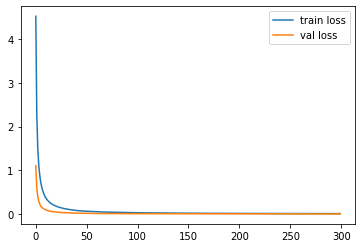

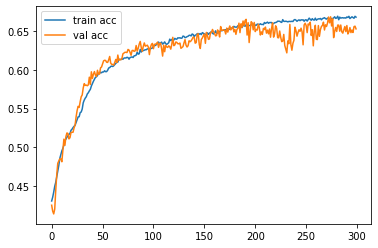

In [174]:
plot_result(train_losses, train_accs, test_losses, test_accs)

In [177]:
# 데이터 전부 사용해서 train 진행

for epoch in range(n_epoch):
    # Training
    train_loss = 0.0
    evaluation = []     # 예측 정확 여부(true, false) 저장 배열
    model.train()
    for features, labels in train_loader:
        features = features.to(device)      # fetures를 device로 보내기
        labels = labels.to(device)   # label을 device로 보내기
        outputs = model(features.to(torch.float))     # 특징을 float형으로 반환 후 모델에 입력
        # float으로 변환하는 과정이 꼭 필요할까?
        
        optimizer.zero_grad()   # optimizer의 gradient를 0으로 초기화
        _, predicted = torch.max(outputs.cpu().data, 1)     # 출력 제일 큰 값의 index 반환

        evaluation.append((predicted == labels.cpu()).tolist())     # 예측이 맞았는지 여부 저장
        loss = criterion(outputs, labels)   # loss 계산

        loss.backward()     # 역전파, 기울기 계산
        optimizer.step()    # 가중치 값 업데이트, 학습 한 번 진행

        train_loss += loss.item()   # loss 누적값 구하기

    train_loss = train_loss / (batch_size * (epoch + 1))   # 평균 train_loss 구하기
    evaluation = [item for sublist in evaluation for item in sublist]   # 2차원 배열을 1차원으로 바꿈
    train_acc = sum(evaluation) / len(evaluation)   # accuracy 구하기 (True 비율)

    print("[%d, %3d]\tloss : %.4f\tAccuracy : %.4f" %
          (epoch + 1, n_epoch, train_loss, train_acc))

[1, 300]	loss : 7.1075	Accuracy : 0.2183
[2, 300]	loss : 3.3309	Accuracy : 0.2639
[3, 300]	loss : 2.1599	Accuracy : 0.3043
[4, 300]	loss : 1.5651	Accuracy : 0.3273
[5, 300]	loss : 1.0885	Accuracy : 0.4050
[6, 300]	loss : 0.8149	Accuracy : 0.4829
[7, 300]	loss : 0.6578	Accuracy : 0.5188
[8, 300]	loss : 0.5683	Accuracy : 0.5287
[9, 300]	loss : 0.4970	Accuracy : 0.5400
[10, 300]	loss : 0.4411	Accuracy : 0.5457
[11, 300]	loss : 0.3945	Accuracy : 0.5561
[12, 300]	loss : 0.3601	Accuracy : 0.5599
[13, 300]	loss : 0.3259	Accuracy : 0.5687
[14, 300]	loss : 0.2984	Accuracy : 0.5778
[15, 300]	loss : 0.2770	Accuracy : 0.5817
[16, 300]	loss : 0.2560	Accuracy : 0.5867
[17, 300]	loss : 0.2391	Accuracy : 0.5916
[18, 300]	loss : 0.2237	Accuracy : 0.5954
[19, 300]	loss : 0.2102	Accuracy : 0.5976
[20, 300]	loss : 0.1996	Accuracy : 0.5979
[21, 300]	loss : 0.1887	Accuracy : 0.5998
[22, 300]	loss : 0.1794	Accuracy : 0.6025
[23, 300]	loss : 0.1698	Accuracy : 0.6072
[24, 300]	loss : 0.1621	Accuracy : 0.6081
[

In [203]:
model.eval()    # parameter 갱신 위해

y_pred = []
for features in test_loader:
    outputs = model(features.to(torch.float))
    _, predicted = torch.max(outputs.cpu().data, 1)
    y_pred += predicted.tolist()
print(len(y_pred))

10000


In [205]:
y_pred[:10]

[7, 2, 1, 1, 4, 1, 2, 6, 5, 7]

In [206]:
submission.loc[:, "label"] = y_pred
submission.to_csv("result_features_mlp.csv", index=False)
submission.head()

,idx,label
0,0,7
1,1,2
2,2,1
3,3,1
4,4,4


제출 결과 acc : 0.63200

-> Bayesian을 사용한 모델보다 성능이 좋지 않다.

### Raw MLP보다 좋아 보이지 않는 이유?
1. 이미지의 크기가 작아 texture의 유사성(glcm)이나 edge 관련 정보(tem)을 쉽사리 추출하기 어렵다.
2. 이미지의 크기가 작다는 것은, 또한 생 이미지를 아무렇게나 mlp에 넣어도 큰 문제가 일어나지 않는다는 점을 시사한다. 그러므로 Raw mlp보다 큰 메리트가 없다.

### GLCM, TEM이 유용하게 쓰이려면?
이미지의 사이즈가 커야 한다. GLCM, TEM은 이미지의 형태에 집중하는 CNN과는 달리 pixel 집합의 특징(texture, edge 등)에 집중하므로, 이미지를 작은 size로 crop한 것에도 잘 작용한다. 그러므로 큰 이미지를 분석할 때, 10x10, 20x20 등으로 이미지를 잘라 둘을 적용시켜 feature vector로 만들면 유용하게 쓸 수 있을 것이다.